# Silicon/Graphite Composite Electrode

A composite electrode particle model is developed for (negative) electrodes with two phases, e.g. graphite/silicon with corresponding cell parameters utilised as the LG M50 cell.

## How to use the model

Let us set up pybamm 

In [ ]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
os.chdir(pybamm.__path__[0]+'/..')
pybamm.set_logging_level("INFO")
plt.rcParams['figure.figsize'] = (20, 10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.5 MB/s eta 0:00:00


Choose the option `{"particle phases": ("2", "1")}` to load the composite electrode particle model by specifying that there are two particle phases (graphite and silicon) in the negative electrode. The parameter set "Chen2020_composite" includes parameters for silicon as a secondary particle. An SPMe model architecture is selected for this notebook via `pybamm.lithium_ion.SPMe`.

In [ ]:
start = timeit.default_timer()
model = pybamm.lithium_ion.DFN({
    "particle phases": ("2", "1"),
    "open circuit potential": (("single", "current sigmoid"), "single")
})
param = pybamm.ParameterValues("Chen2020_composite")

param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2.5})

param.update({
    "Primary: Maximum concentration in negative electrode [mol.m-3]":33133,#28700,
    "Primary: Initial concentration in negative electrode [mol.m-3]":30171,#23000,
    "Primary: Negative electrode diffusivity [m2.s-1]":5.5E-14,
    "Secondary: Negative electrode diffusivity [m2.s-1]":1.67E-14,
    "Secondary: Initial concentration in negative electrode [mol.m-3]":277000,
    "Secondary: Maximum concentration in negative electrode [mol.m-3]":278000
})

2023-02-15 20:19:44.336 - [INFO] base_model._build_model(550): Start building Doyle-Fuller-Newman model
INFO:pybamm.logger:Start building Doyle-Fuller-Newman model
2023-02-15 20:19:44.442 - [INFO] base_battery_model.build_model(967): Finish building Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish building Doyle-Fuller-Newman model


Define a current loading

In [ ]:
# C_rate = 0.5
# capacity = param["Nominal cell capacity [A.h]"]
# I_load = C_rate * capacity  

# t_eval = np.linspace(0,10000,1000)

# param["Current function [A]"] = I_load

experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/20 until 3.0 V",
            "Rest for 1 hour",
            # "Discharge at 0.1C until 3.0 V",
            # "Rest for 1 hour",
            "Charge at C/20 until 4.2 V",
            "Rest for 1 hour",
        ),
    ]
    * 1
)

It is very easy to vary the relative volume fraction of each phase. The following example shows how to compare the results of batteries with three relative volume fractions (0.001, 0.04, 0.1) of silicon.

In [ ]:
v_si=[0.001,0.1,0.2,0.3]
total_am_volume_fraction = 0.75
solution=[]
for v in v_si:
    param.update({
        "Primary: Negative electrode active material volume fraction": (1-v) * total_am_volume_fraction, #primary
        "Secondary: Negative electrode active material volume fraction": v * total_am_volume_fraction,
    })
    print(v)
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        parameter_values=param,
        solver=pybamm.CasadiSolver(dt_max = 10)
    )
    solution.append(sim.solve(calc_esoh=False))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2023-02-15 20:23:09.006 - [INFO] callbacks.on_experiment_start(166): Start running experiment
INFO:pybamm.logger:Start running experiment
2023-02-15 20:23:09.013 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Start setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:23:09.138 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:23:09.142 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Start setting parameters for Doyle-Fuller-Newman model


0.001


2023-02-15 20:23:09.455 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:23:09.462 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Start setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:23:09.589 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:23:09.596 - [INFO] discretisation.process_model(148): Start discretising Doyle-Fuller-Newman model
INFO:pybamm.logger:Start discretising Doyle-Fuller-Newman model
2023-02-15 20:23:09.608 - [INFO] discretisation.remove_independent_variables_from_rhs(1123): removing variable Discharge capacity [A.h] from rhs
INFO:pybamm.logger:removing variable Discharge capacity [A.h] from rhs
2023-0

0.1


2023-02-15 20:24:05.359 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:24:05.365 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Start setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:24:05.481 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:24:05.489 - [INFO] discretisation.process_model(148): Start discretising Doyle-Fuller-Newman model
INFO:pybamm.logger:Start discretising Doyle-Fuller-Newman model
2023-02-15 20:24:05.499 - [INFO] discretisation.remove_independent_variables_from_rhs(1123): removing variable Discharge capacity [A.h] from rhs
INFO:pybamm.logger:removing variable Discharge capacity [A.h] from rhs
2023-0

0.2


2023-02-15 20:25:16.394 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:25:16.400 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Start setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:25:16.559 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:25:16.568 - [INFO] discretisation.process_model(148): Start discretising Doyle-Fuller-Newman model
INFO:pybamm.logger:Start discretising Doyle-Fuller-Newman model
2023-02-15 20:25:16.578 - [INFO] discretisation.remove_independent_variables_from_rhs(1123): removing variable Discharge capacity [A.h] from rhs
INFO:pybamm.logger:removing variable Discharge capacity [A.h] from rhs
2023-0

0.3


2023-02-15 20:26:27.596 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:26:27.602 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Start setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:26:27.715 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
INFO:pybamm.logger:Finish setting parameters for Doyle-Fuller-Newman model
2023-02-15 20:26:27.724 - [INFO] discretisation.process_model(148): Start discretising Doyle-Fuller-Newman model
INFO:pybamm.logger:Start discretising Doyle-Fuller-Newman model
2023-02-15 20:26:27.738 - [INFO] discretisation.remove_independent_variables_from_rhs(1123): removing variable Discharge capacity [A.h] from rhs
INFO:pybamm.logger:removing variable Discharge capacity [A.h] from rhs
2023-0

running time: 506.575665703s


## Results
Compare the cell voltages of the three cells in this example, to see how silicon affects the output capacity

Results of interfacial current density in silicon

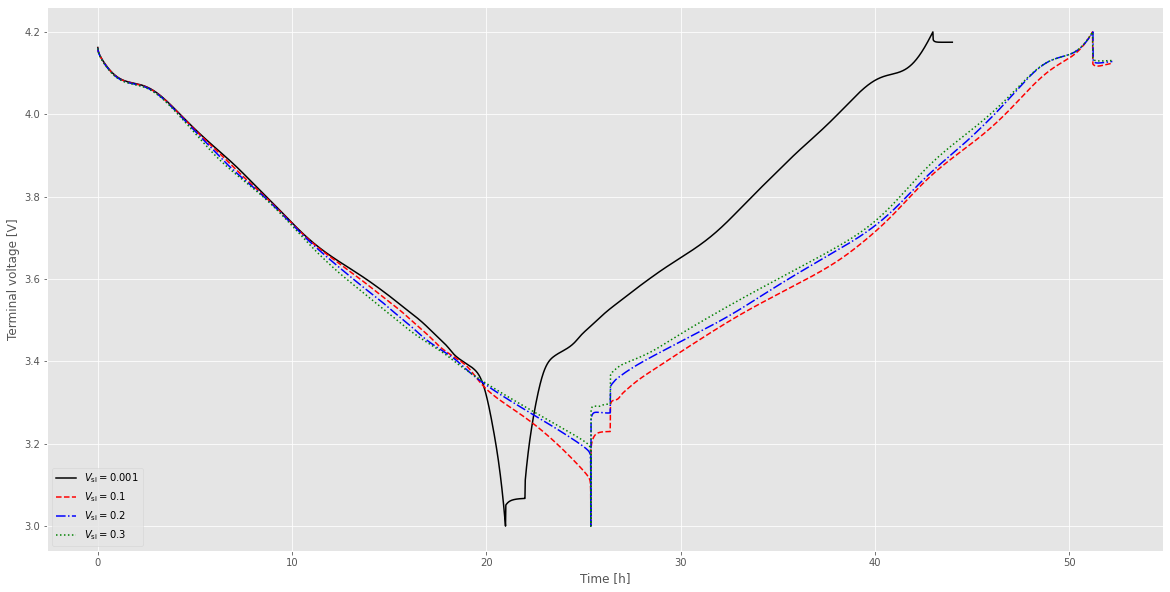

In [ ]:
ltype=['k-','r--','b-.','g:','m-','c--','y-.'];
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Terminal voltage [V]"].entries
    plt.plot(t_i, V_i,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Terminal voltage [V]')
plt.legend()

SOC Comparision,

In [ ]:
model.variables.search("nominal")

No results for search using 'nominal'. Best matches are []


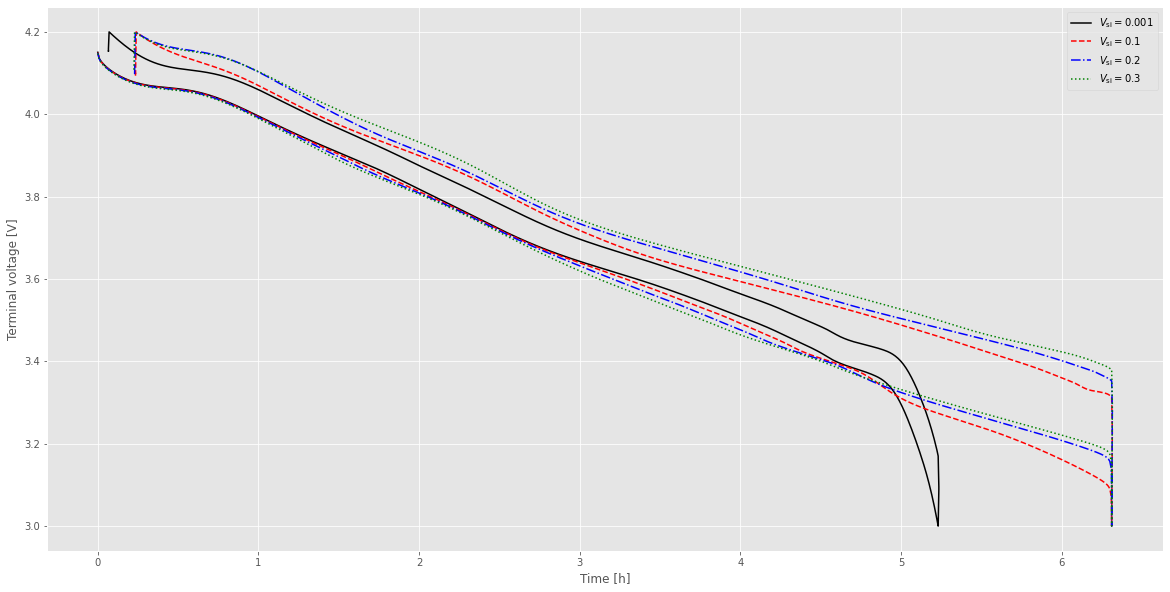

In [ ]:
ltype=['k-','r--','b-.','g:','m-','c--','y-.'];
for i in range(0,len(v_si)):
    t_i = solution[i]["Discharge capacity [A.h]"].entries
    V_i = solution[i]["Terminal voltage [V]"].entries
    plt.plot(t_i, V_i,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Terminal voltage [V]')
plt.legend()

Postive Electrode Stoich,

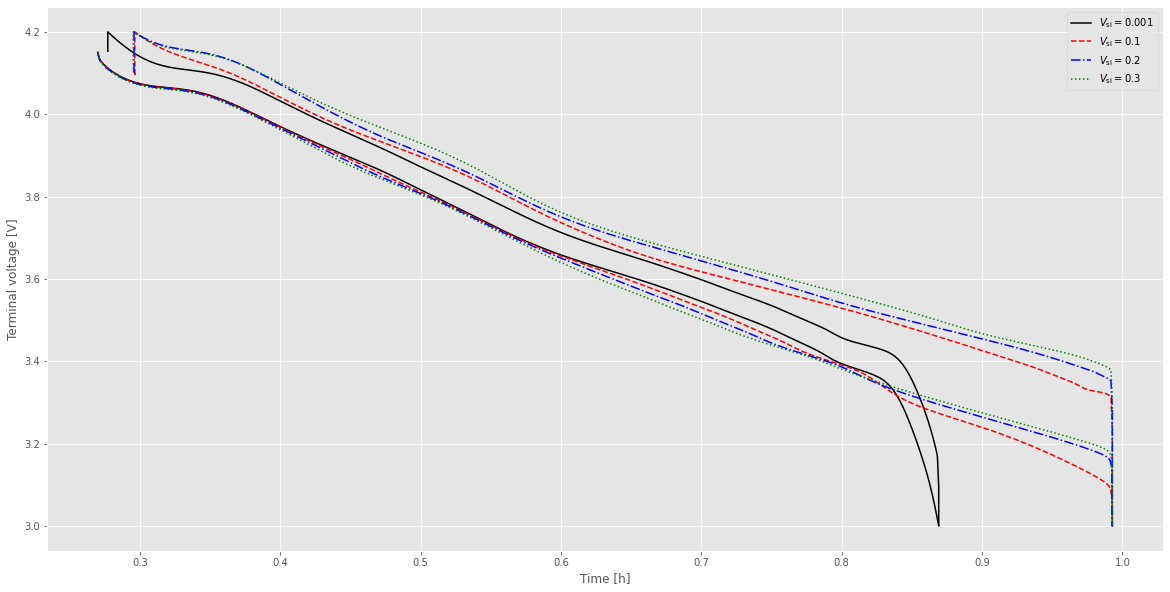

In [ ]:
ltype=['k-','r--','b-.','g:','m-','c--','y-.'];
for i in range(0,len(v_si)):
    t_i = solution[i]["Positive electrode stoichiometry"].entries
    V_i = solution[i]["Terminal voltage [V]"].entries
    plt.plot(t_i, V_i,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Terminal voltage [V]')
plt.legend()

Text(0.5, 1.0, 'Silicon')

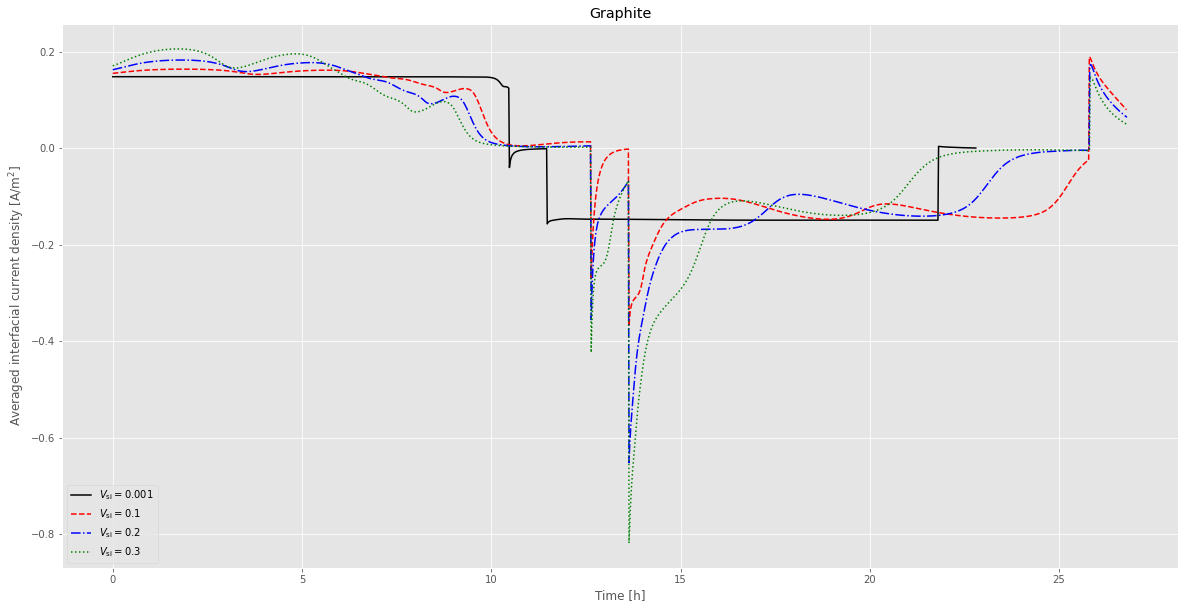

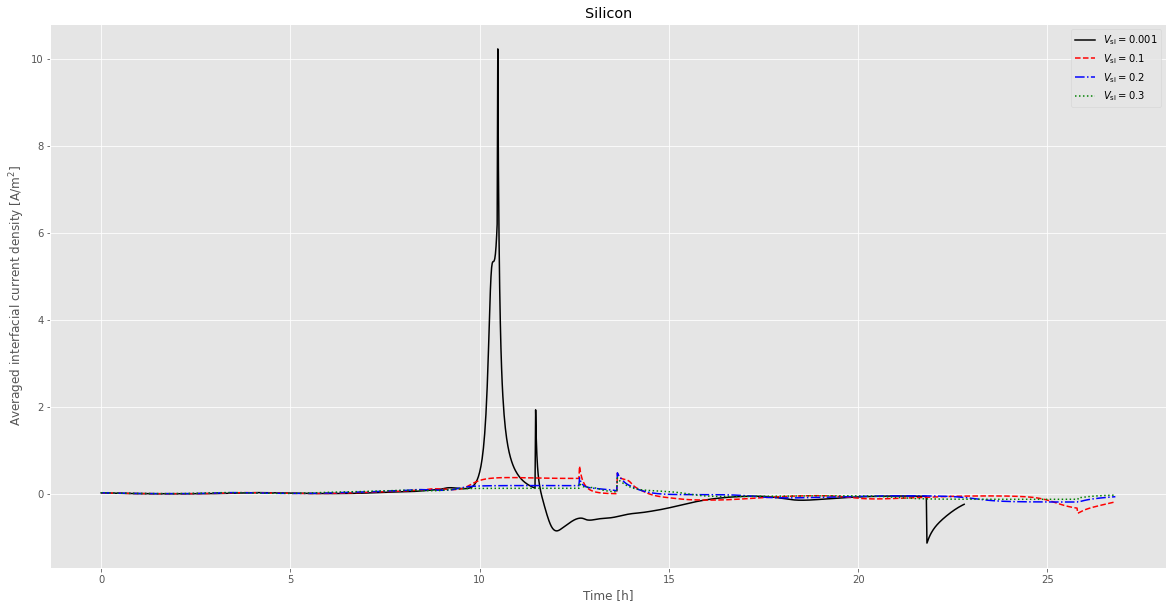

In [ ]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_av = solution[i]["X-averaged negative electrode primary interfacial current density [A.m-2]"].entries
    plt.plot(t_i, j_n_p1_av,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_av = solution[i]["X-averaged negative electrode secondary interfacial current density [A.m-2]"].entries
    plt.plot(t_i, j_n_p2_av,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Silicon')

Results of interfacial current density in graphite

Text(0.5, 1.0, 'Silicon')

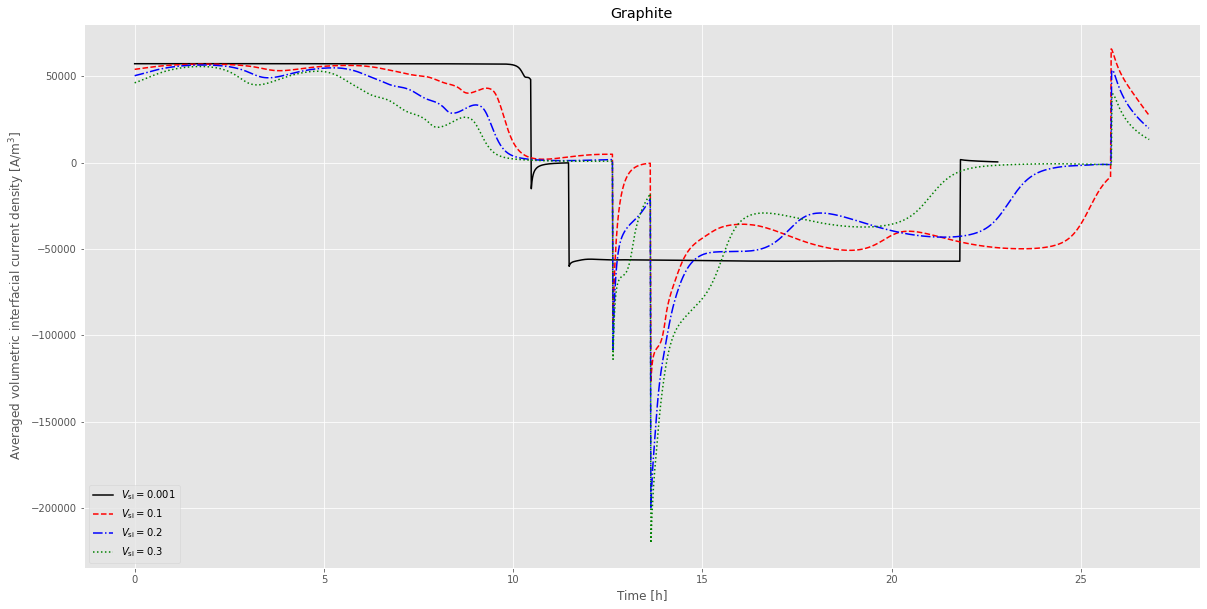

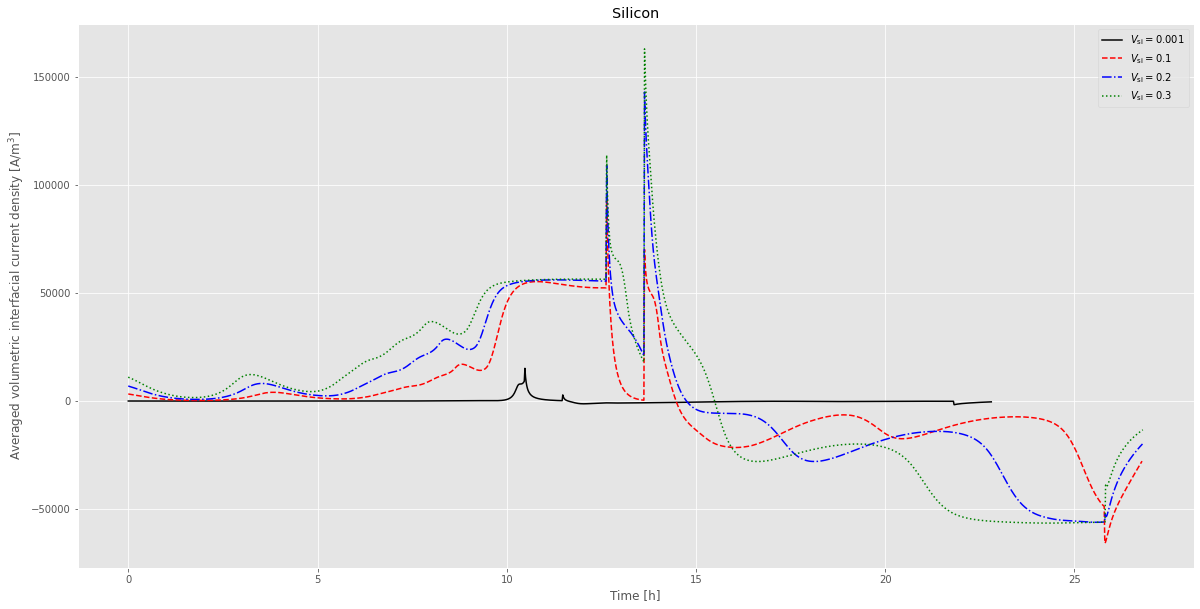

In [ ]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_Vav = solution[i]["X-averaged negative electrode primary volumetric interfacial current density [A.m-3]"].entries
    plt.plot(t_i, j_n_p1_Vav,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged volumetric interfacial current density [A/m$^{3}$]')
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_Vav = solution[i]["X-averaged negative electrode secondary volumetric interfacial current density [A.m-3]"].entries
    plt.plot(t_i, j_n_p2_Vav,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged volumetric interfacial current density [A/m$^{3}$]')
plt.legend()
plt.title('Silicon')

Results of average lithium concentration

Text(0.5, 1.0, 'Silicon')

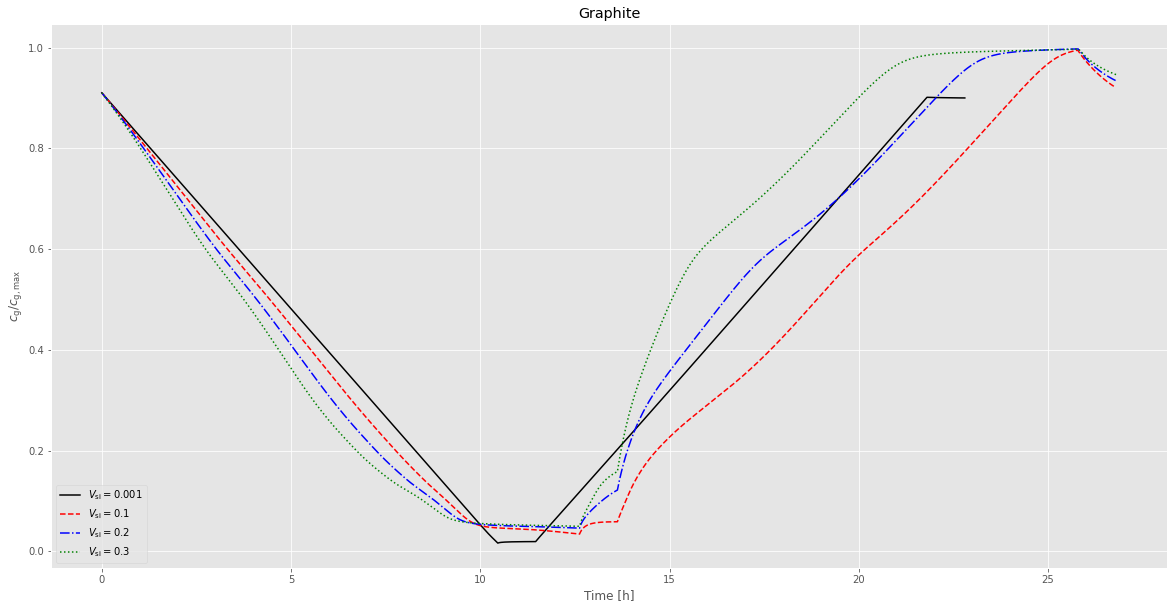

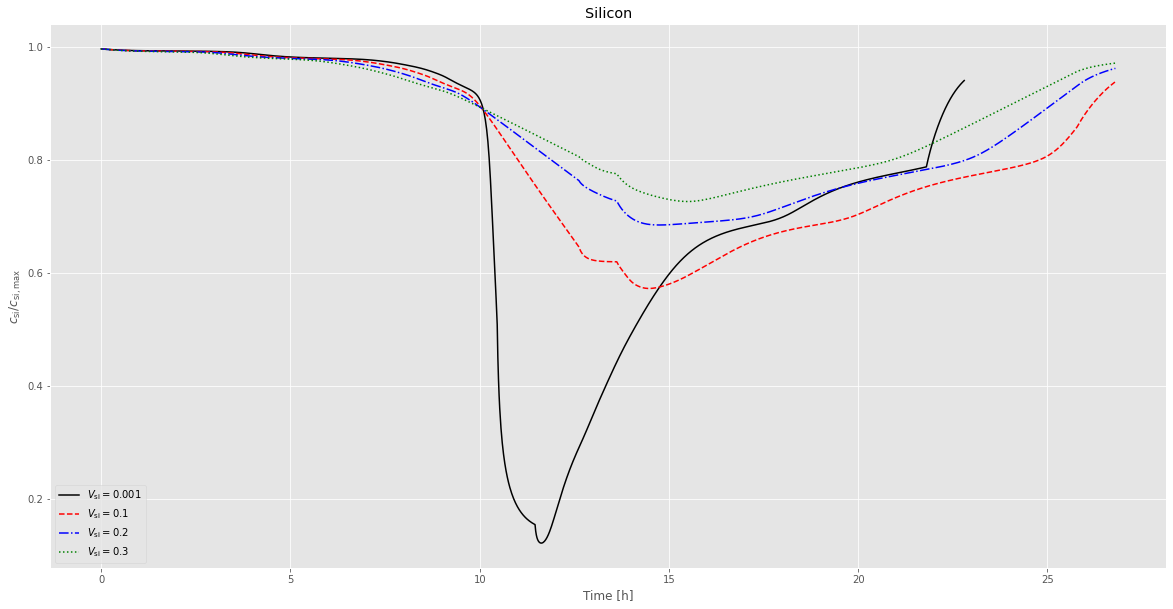

In [ ]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p1 = solution[i]["Average negative primary particle concentration"].entries
    plt.plot(t_i, c_s_xrav_n_p1 ,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("$c_\mathrm{g}/c_\mathrm{g,max}$")
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p2 = solution[i]["Average negative secondary particle concentration"].entries
    plt.plot(t_i, c_s_xrav_n_p2,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("$c_\mathrm{si}/c_\mathrm{si,max}$")
plt.legend()
plt.title('Silicon')

Results of equilibrium potential

Text(0.5, 1.0, 'NMC811')

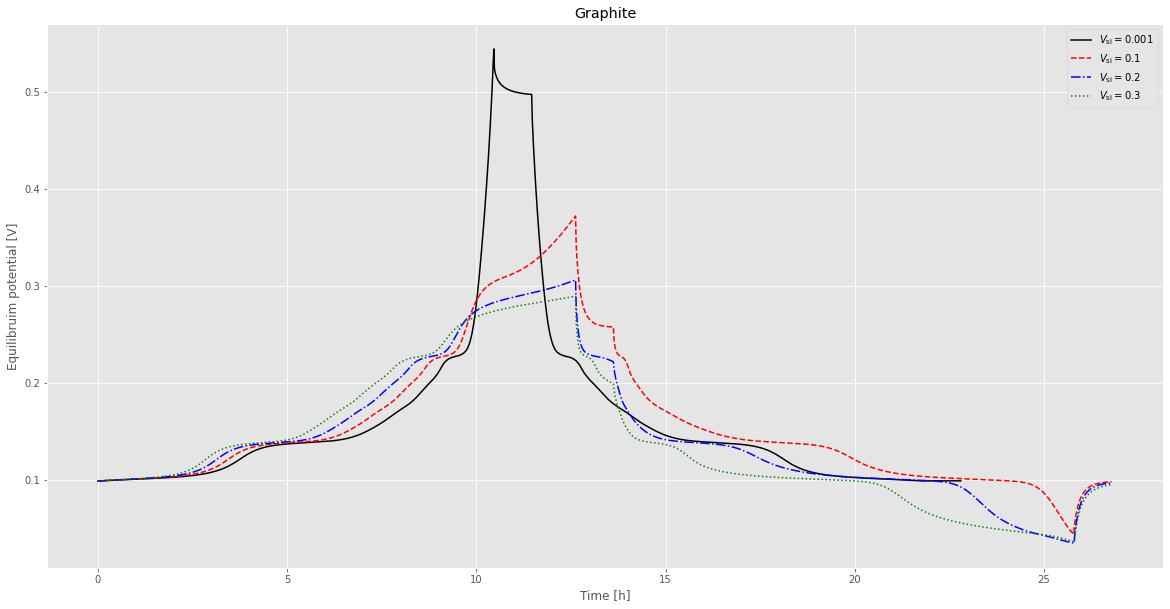

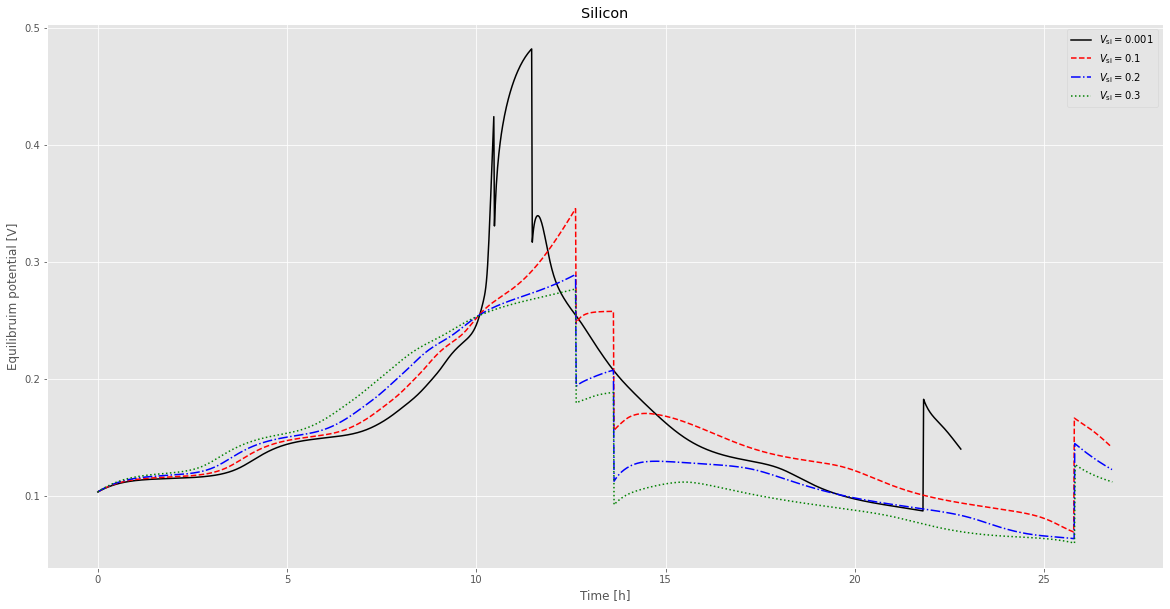

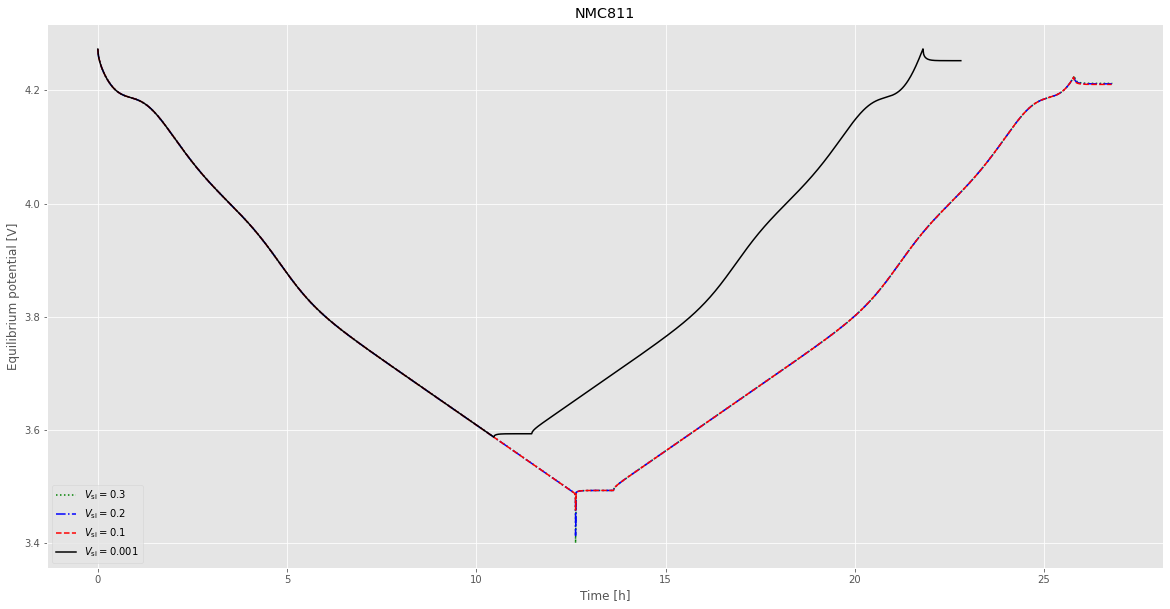

In [ ]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p1 = solution[i]["X-averaged negative electrode primary open circuit potential [V]"].entries
    plt.plot(t_i, ocp_p1 ,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p2 = solution[i]["X-averaged negative electrode secondary open circuit potential [V]"].entries
    plt.plot(t_i, ocp_p2,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('Silicon')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[len(v_si)- 1 - i]["Time [s]"].entries / 3600
    ocp_p = solution[len(v_si)- 1 - i]["X-averaged positive electrode open circuit potential [V]"].entries
    plt.plot(t_i, ocp_p,ltype[len(v_si)- 1 - i],label="$V_\mathrm{si}=$"+str(v_si[len(v_si)- 1 - i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibrium potential [V]")
plt.legend()
plt.title('NMC811')

## References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()

ImportError: ignored